### **Спринт №1. Многоклассовое прогнозирование исходов цирроза печени**

## Цель работы: предсказать вероятность каждого из трех значений Status, например Status_C, Status_CL, Status_D..

Status — категориальная цель; C  означает, что пациент был жив в N_Days,
CL означает, что пациент был жив в N_Days из-за трансплантации печени,
а D означает, что пациент умер в N_Days.

train.csv — набор данных для обучения;

test.csv — набор данных для тестирования;

sample_submission.csv — файл отправки образца в правильном формате


Источник: https://www.kaggle.com/competitions/playground-series-s3e26/


Описание: набор данных для многоклассового прогнозирования исходов цирроза печени


Целевая переменная: Статус (от нее будет рассчитана вероятность исхода цирроза печени)

Признаки:

id - идентификационный номер пациента

N_Days - количество дней

Drug - лекарство

Age - возраст пациента

Sex - пол

Ascites - Асцит (водянка живота) — патологическое состояние, характеризующееся скоплением жидкости в брюшной полости

Hepatomegaly - Гепатомегалия  (патологическое состояние, которое характеризуется неестественным увеличением и признаками диффузных изменений печени)

Spiders - паукообразный невус

Edema - отек, водянка

Bilirubin - билирубин

Cholesterol - холестерин

Albumin - альбумин

Copper - медь

Alk_Phos - щелочная фосфотаза (оптимум ферментативной активности при значениях pH 7,5)

SGOT - фермент АСТ (аспартат аминотрансфераза)

Tryglicerides - триглицериды

Platelets - тромбоциты

Prothrombin - протромбин; фактор (свертывающей системы крови)

Stage - стадия

Status - статус (C, D, CL)

In [120]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_sd = pd.read_csv('/content/sample_submission.csv')



Предварительный анализ данных

In [54]:
#Посмотрим на столбцы и типы данных для train

df_train.head(20).style.set_properties(**{"background-color": "#A8DADC", "color": "black", "border": "1.5px solid White"})


In [ ]:
#Посмотрим на столбцы и типы данных для test

df_test.head().style.set_properties(**{"background-color": "#FF69B4", "color": "black", "border": "1.5px solid White"})

In [ ]:
#Посмотрим на столбцы и типы данных для sample_submission

df_sd.head().style.set_properties(**{"background-color": "#FFFACD", "color": "black", "border": "1.5px solid White"})

In [ ]:
df_train.shape,df_test.shape,df_sd.shape

((7905, 20), (5271, 19), (5271, 4))

In [ ]:
# тип столбцов
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [ ]:
# Основные показатели статистики для train
df_train.describe().style.background_gradient()

In [ ]:
# Основные показатели статистики для test
df_test.describe().style.background_gradient()


In [ ]:
# Дубликаты
df_train.duplicated(). sum()

0

In [ ]:
# Дубликаты
df_test.duplicated(). sum()

0

In [ ]:
df_train.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [ ]:
# маска/количество пропусков в данных
null_d=df_train. isnull().sum()
print (null_d[null_d>0])

Series([], dtype: int64)


In [ ]:
df_test.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [ ]:
#Узнаем, как распределяются по количеству статусы в тренировочном датасете
df_train['Status'].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

*Количество живых пациентов в определнный промежуток времени практически в 2 раза превышает смертность и практически в 18 раз выше живых пациентов с трансплантацией*

Анализ данных

<Axes: >

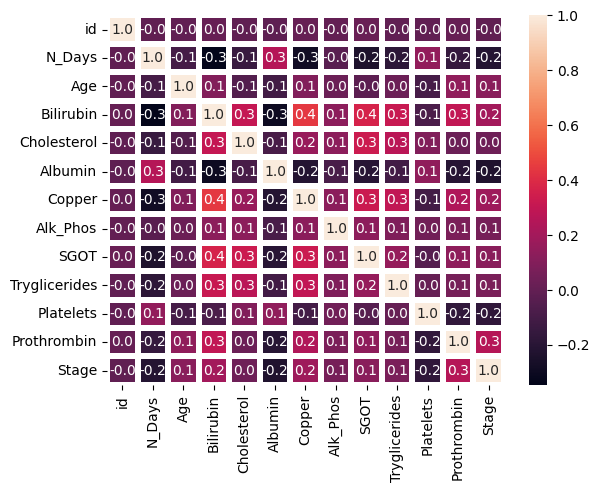

In [ ]:
# если есть корреляция между признаками, то признаки можно исключить

num_cols = df_train.select_dtypes(include='number').columns
corr_matrix = df_train[num_cols].corr()
corr_matrix

sns.heatmap(corr_matrix, annot=True, fmt='.1f', linewidth=4)

Сильной корреляции между признаками (> 0.6-0.7), при которой часть признаков можно не учитывать при обучении - не выявлено. Наибольшая корреляция (на уровне 0,4) наблюдается между признаками медь-билирубин, АСТ-билирубин. Корреляция на уровне 0,3 - между признаком количества дней и ключевыми показателями для печени для крови (билирубин, альбумин).

1. Построим графики распределения данных.

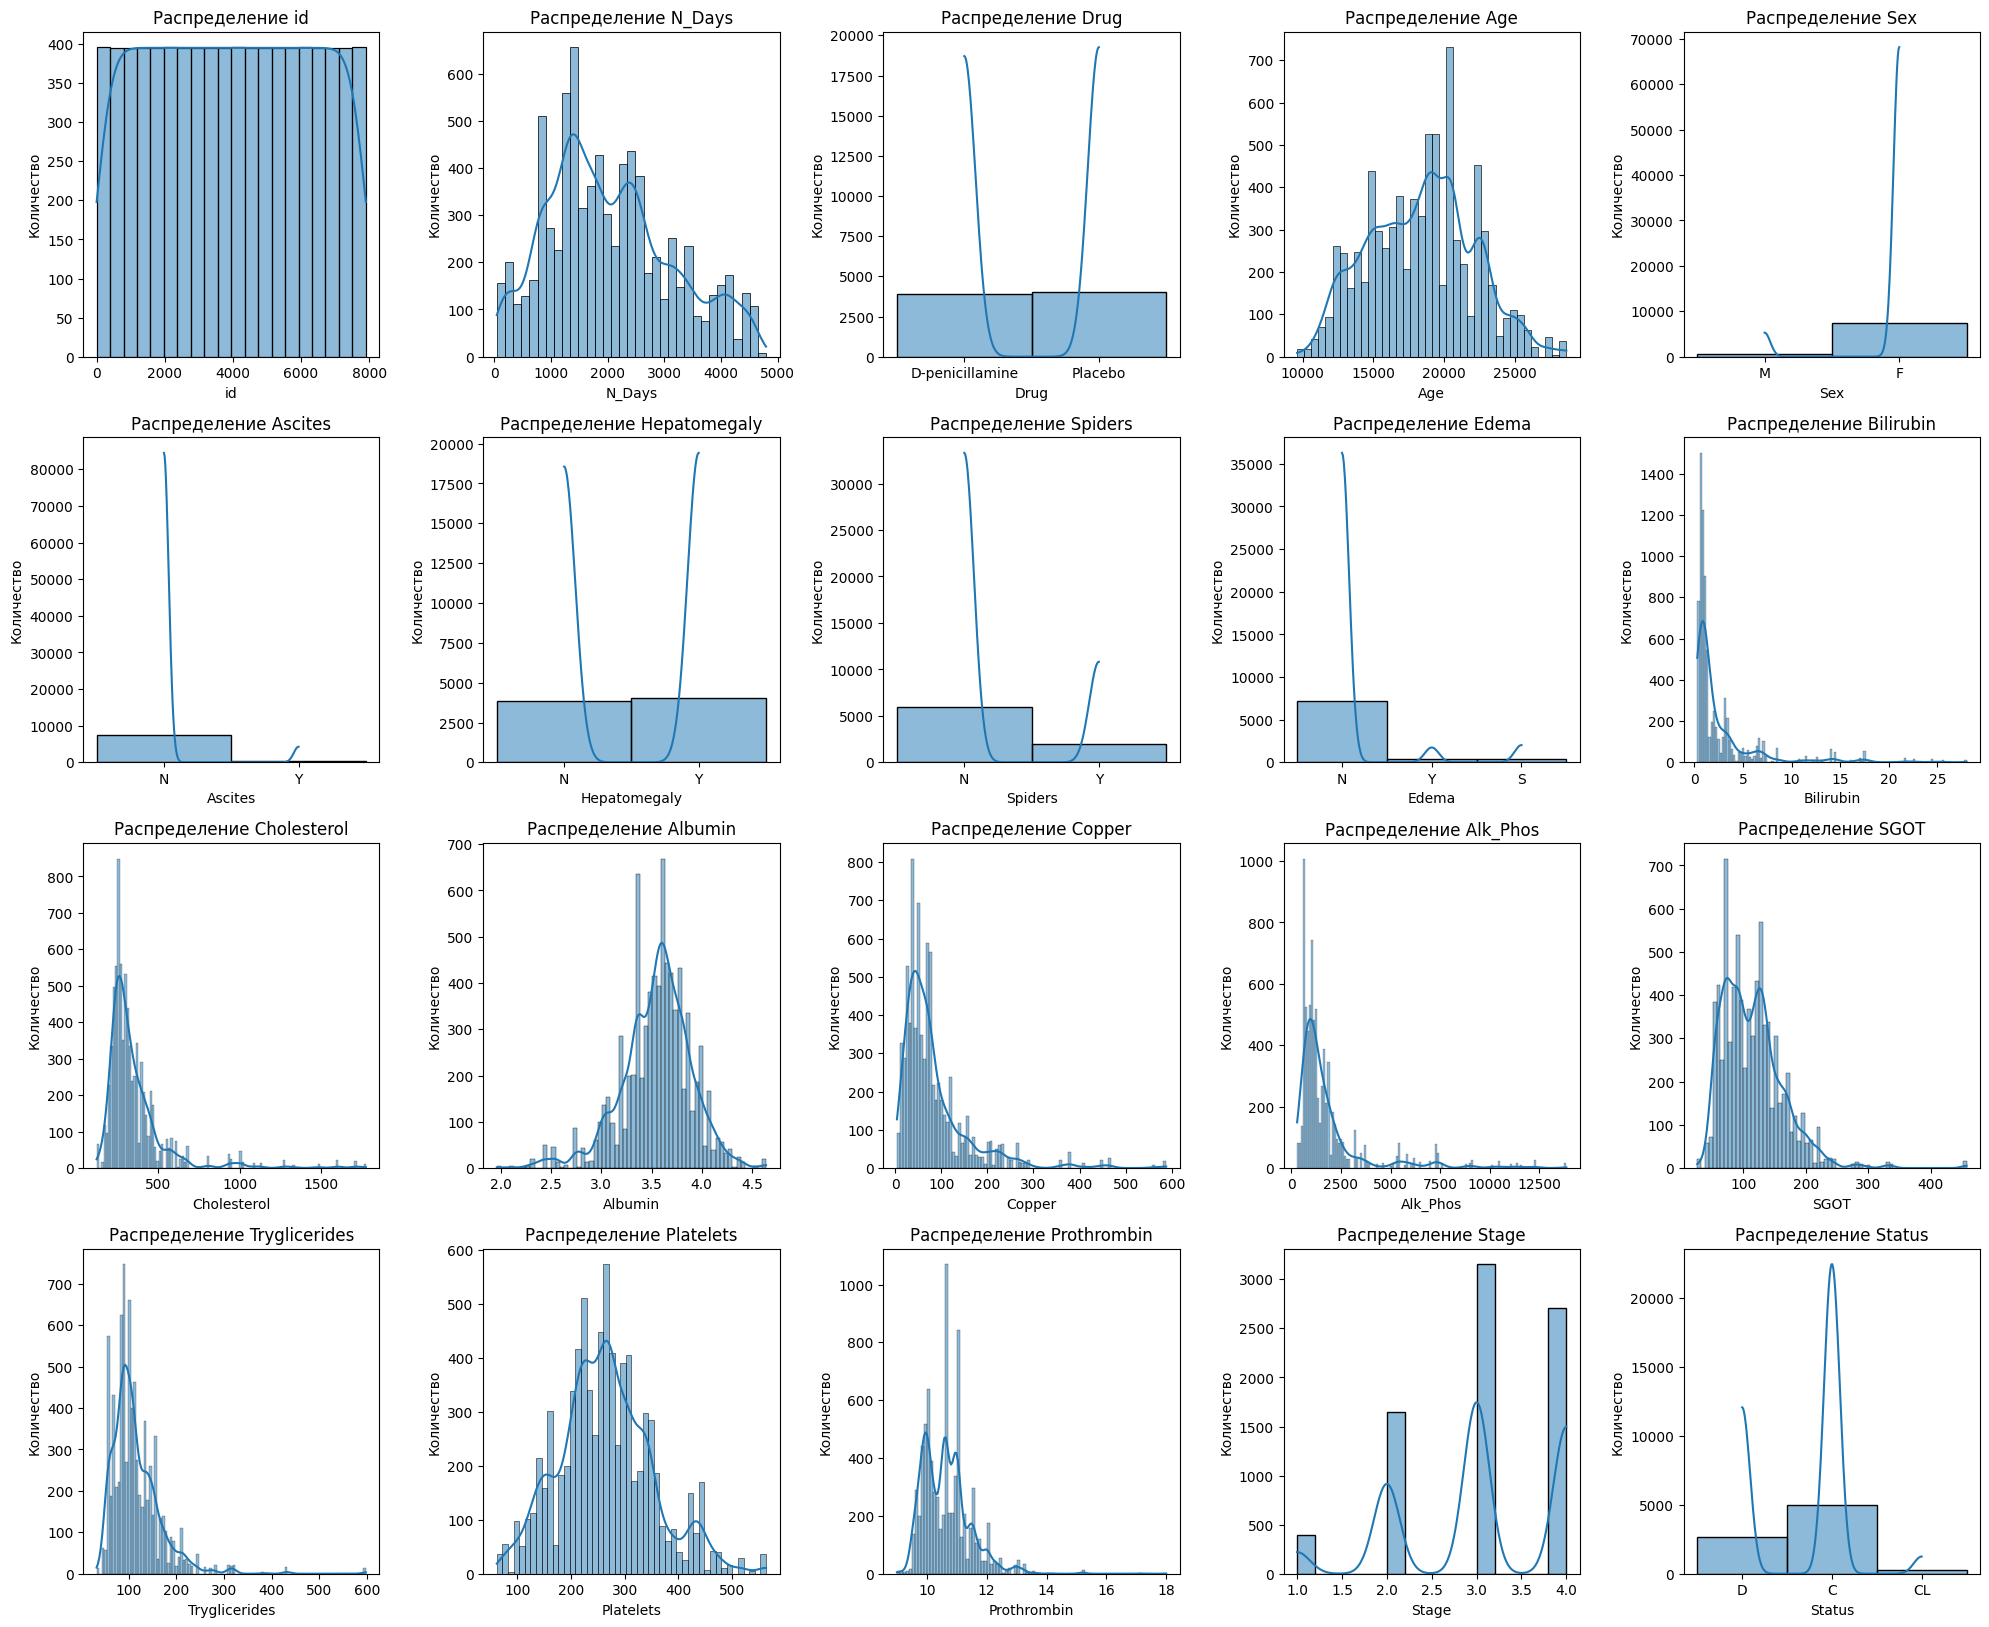

In [ ]:
# Изучим распределение данных для train
# Установка размеров графиков
plt.figure(figsize=(20, 20))

# Перебор каждого столбца
for i, column in enumerate(df_train.columns):
    plt.subplot(5, 5, i + 1)  # 5 строк и 5 столбцов
    sns.histplot(df_train[column], kde=True)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')

plt.tight_layout()  # Убираем наложение графиков
plt.show()

Из графиков можно сделать вывод о распределении данных в train:
1) распределение по лекарствам - примерно одинаковое;
2) в выборке исследования преобладают преимущественно женщины;
3) наличие асцита у пациентов в выборке мало;
4) наличие гепатомегалии - примерно 50/50;
5) паукообразный невус в большей степени у пациентов отсутствует;
6) преобладает отсутсвие водянки у пациентов
7) статус С преобладает над смертностью D практически вдое, пациентов со статусов CL меньше всего

In [ ]:
# Посмотрим баланс классов для признаков пол, водянка, асцит, статус
df_train.Sex.value_counts()


Sex
F    7336
M     569
Name: count, dtype: int64

Женщин практически в 13 раз больше мужчин

In [ ]:
df_train.Ascites.value_counts()

Ascites
N    7525
Y     380
Name: count, dtype: int64

Пациентов с наличием асцита практически в 30 раз меньше, чем пациентов, у которых он отсутствует

In [ ]:
df_train.Edema.value_counts()

Edema
N    7161
S     399
Y     345
Name: count, dtype: int64

Пациентов без водянки практически в 18 раз больше, чем пациентов с водянкой

In [ ]:
df_train.Status.value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

2. Построим ящики с усами для числовых признаков. Зафиксируем признаки с выбросами.

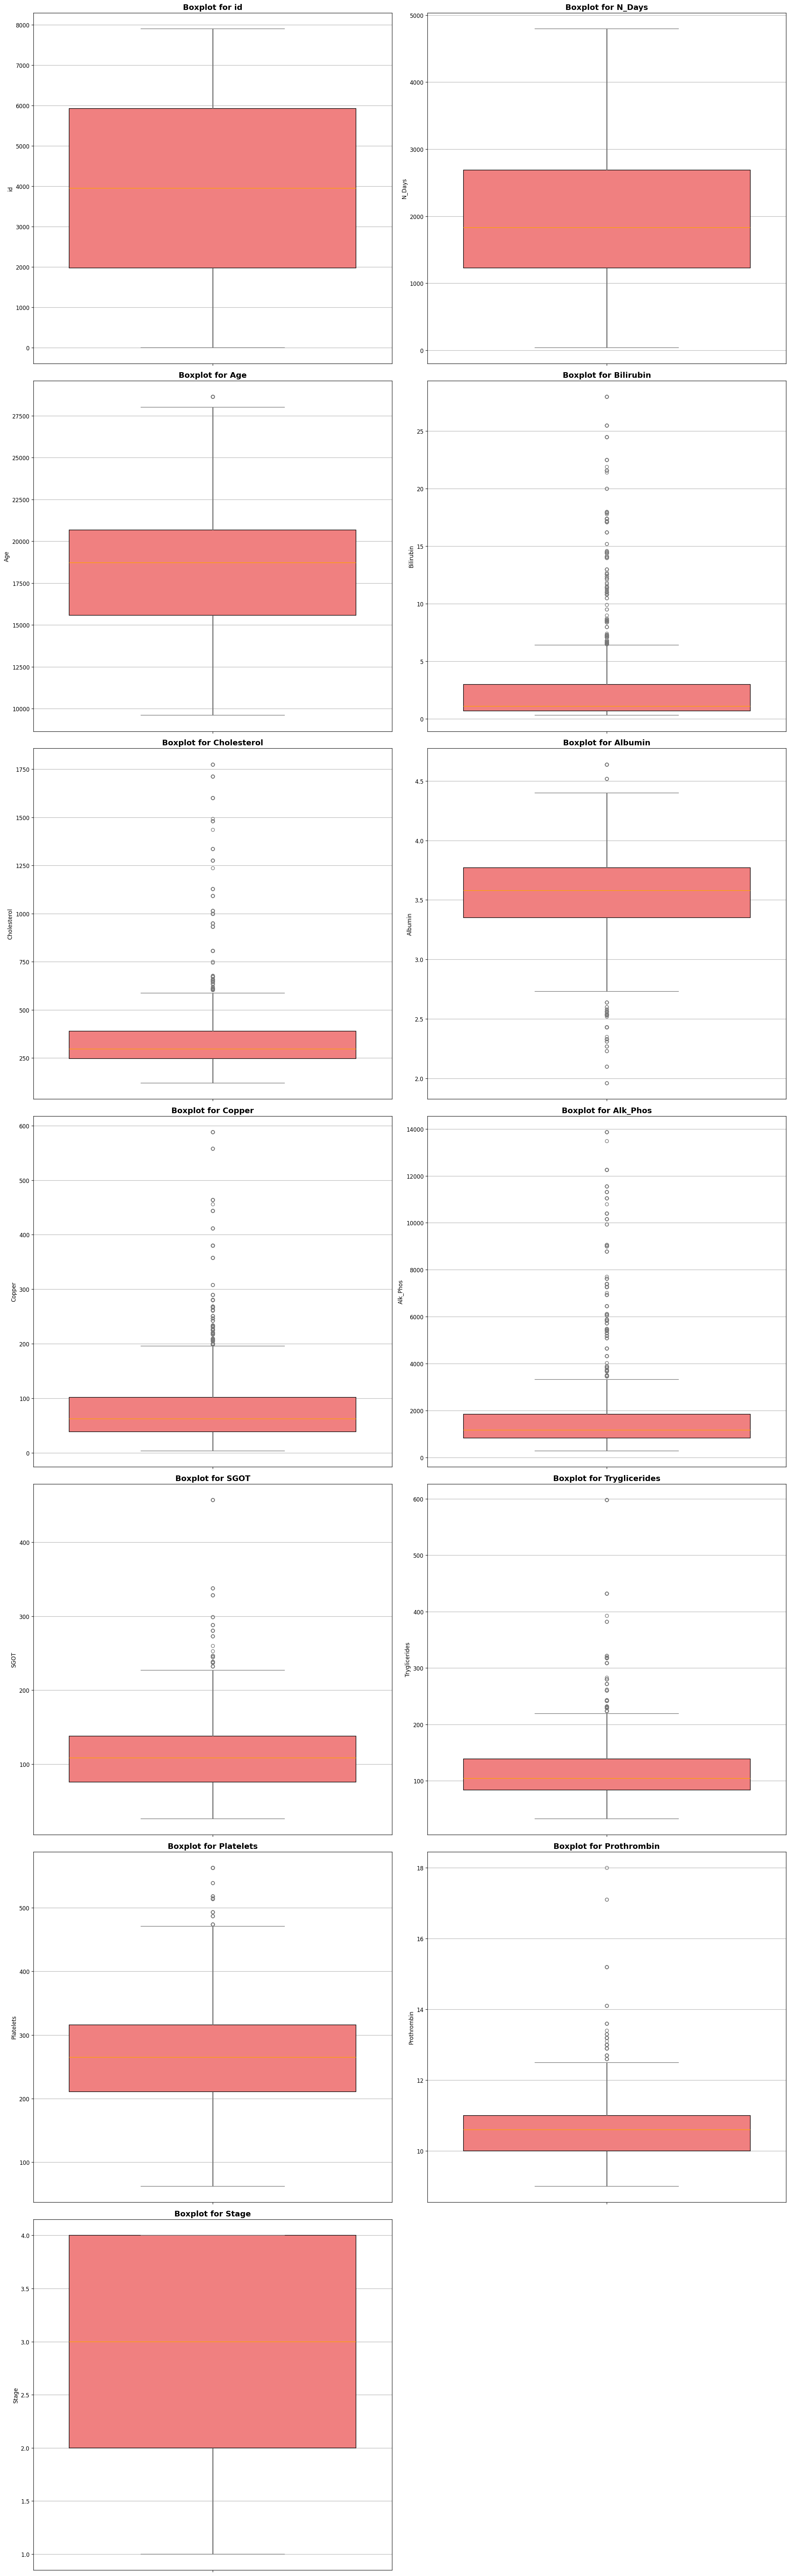

Выбросы в признаке id:
Empty DataFrame
Columns: [id, N_Days, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage, Status]
Index: []
Выбросы в признаке N_Days:
Empty DataFrame
Columns: [id, N_Days, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage, Status]
Index: []
Выбросы в признаке Age:
        id  N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders  \
179    179     930          Placebo  28650   M       N            Y       N   
480    480    1765          Placebo  28650   F       N            Y       N   
515    515    1765  D-penicillamine  28650   F       Y            Y       Y   
1098  1098    1765  D-penicillamine  28650   M       Y            Y       N   
1195  1195    2692  D-penicillamine  28650   F       N            N       N   
1901  1901    1765  D-pe

In [ ]:
# Определение числовых признаков
numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns

# Построение графика "ящик с усами"
plt.figure(figsize=(20, 65), dpi=120)  # Увеличение размера графика и разрешения
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//2 + 1, 2, i + 1)
    sns.boxplot(y=df_train[col], color='lightblue', whiskerprops={'linewidth': 2},
                boxprops={'facecolor': 'lightcoral', 'edgecolor': 'black'},
                medianprops={'color': 'orange'})
    plt.title(f'Boxplot for {col}', fontsize=14, fontweight='bold')  # Улучшение заголовка
    plt.xlabel('')  # Убрать метку по оси X
    plt.grid(axis='y')  # Добавление сетки для лучшей читабельности

plt.tight_layout()
plt.show()

# Фиксация выбросов
outliers = {}
for col in numeric_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]

# Вывод выбросов
for col, outlier_df_train in outliers.items():
    print(f'Выбросы в признаке {col}:')
    print(outlier_df_train)

3. Зафиксируйте признаки с существенным дисбалансом значений.

In [ ]:

# Определяем порог дисбаланса
threshold = 0.5

# Определение дисбалансных числовых признаков
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns
imbalanced_numeric_features = []

for column in numeric_columns:
    if df_train[column].nunique() / len(df_train) < threshold:  # менее 50% уникальных значений
        imbalanced_numeric_features.append(column)
        print(f'Column: {column} has significant imbalance.')

Column: N_Days has significant imbalance.
Column: Age has significant imbalance.
Column: Bilirubin has significant imbalance.
Column: Cholesterol has significant imbalance.
Column: Albumin has significant imbalance.
Column: Copper has significant imbalance.
Column: Alk_Phos has significant imbalance.
Column: SGOT has significant imbalance.
Column: Tryglicerides has significant imbalance.
Column: Platelets has significant imbalance.
Column: Prothrombin has significant imbalance.
Column: Stage has significant imbalance.


4. Для зафиксированных признаков проведите дополнительный анализ данных: постройте графики количества значений. Сохраните каждый график как картинку.

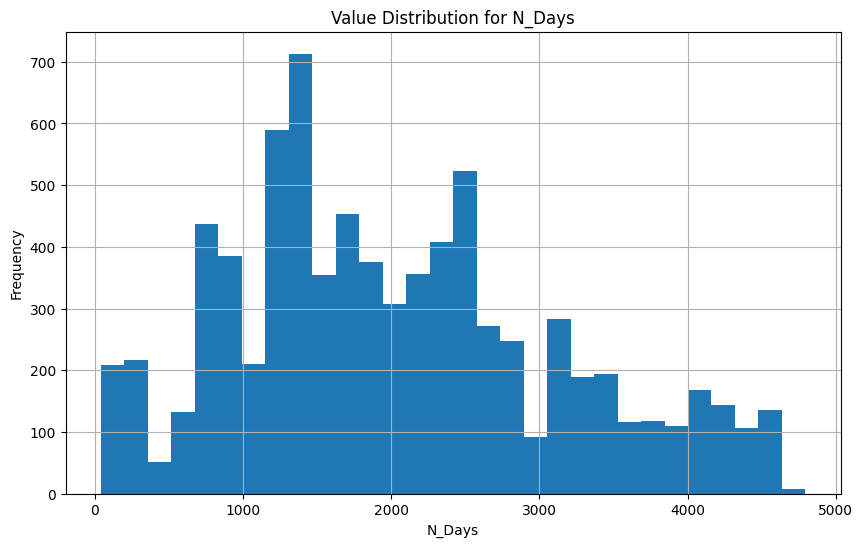

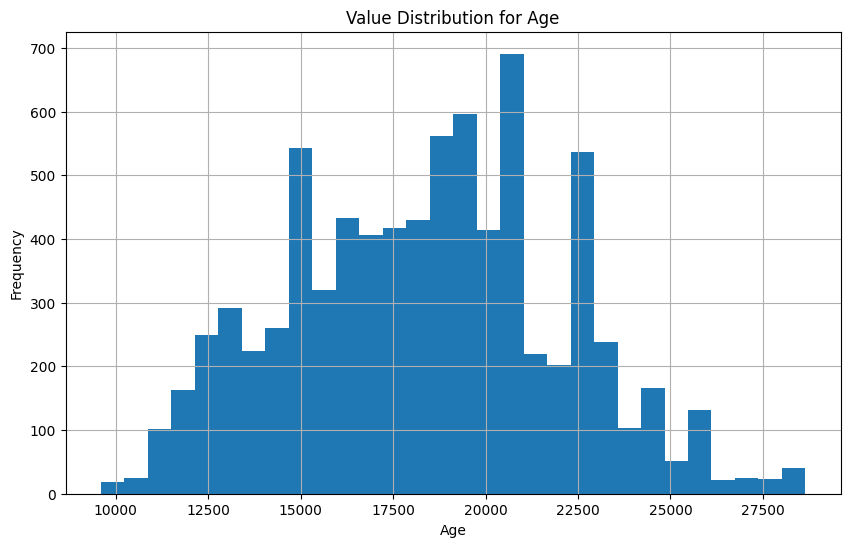

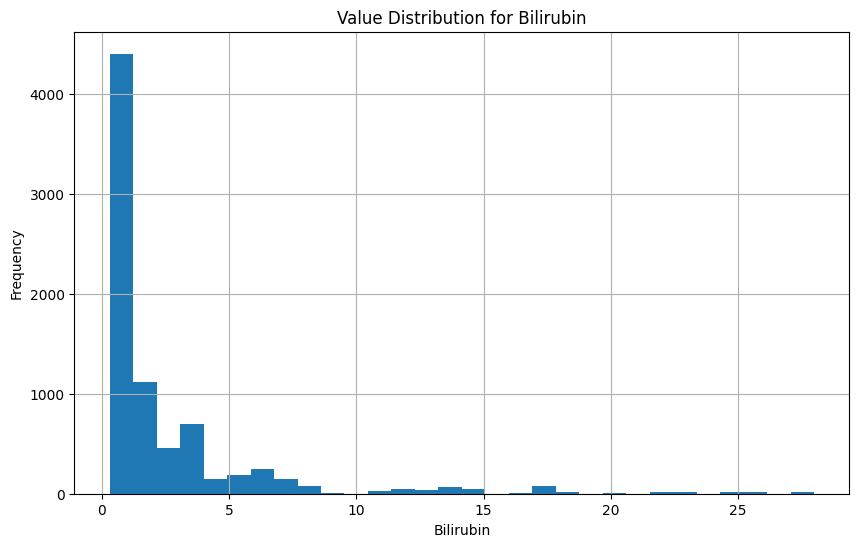

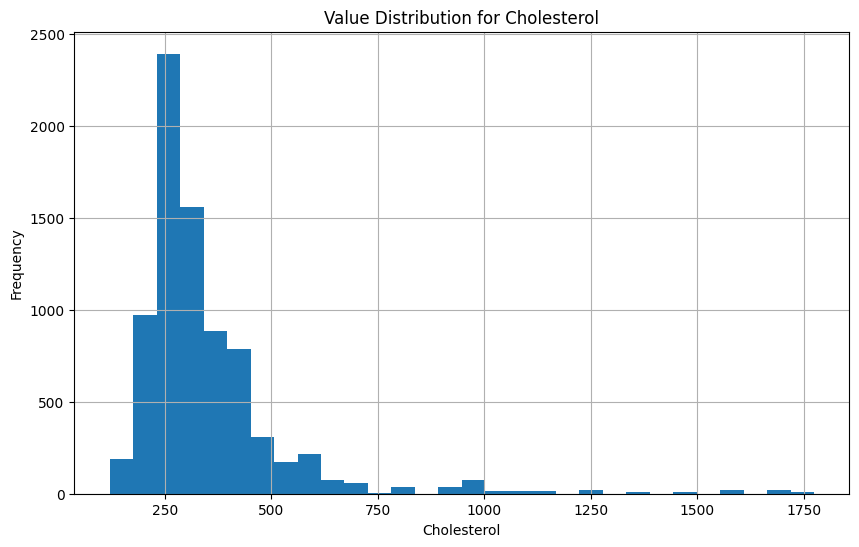

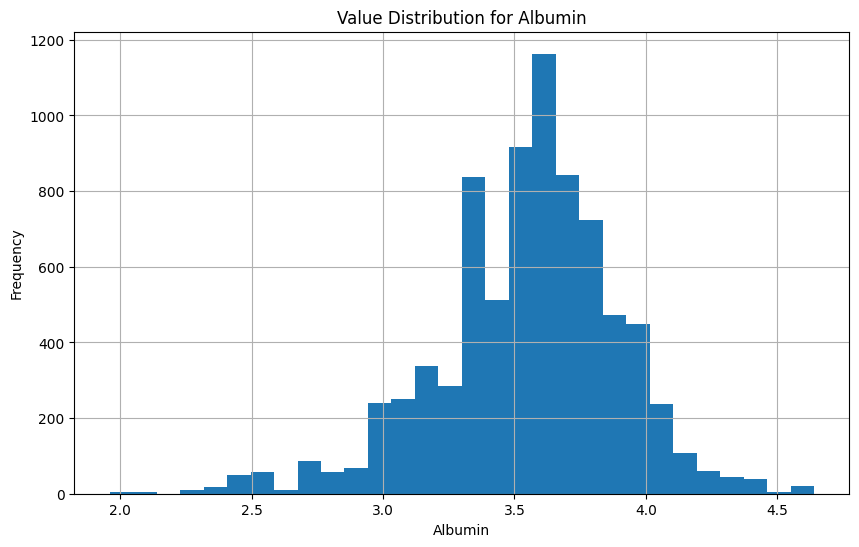

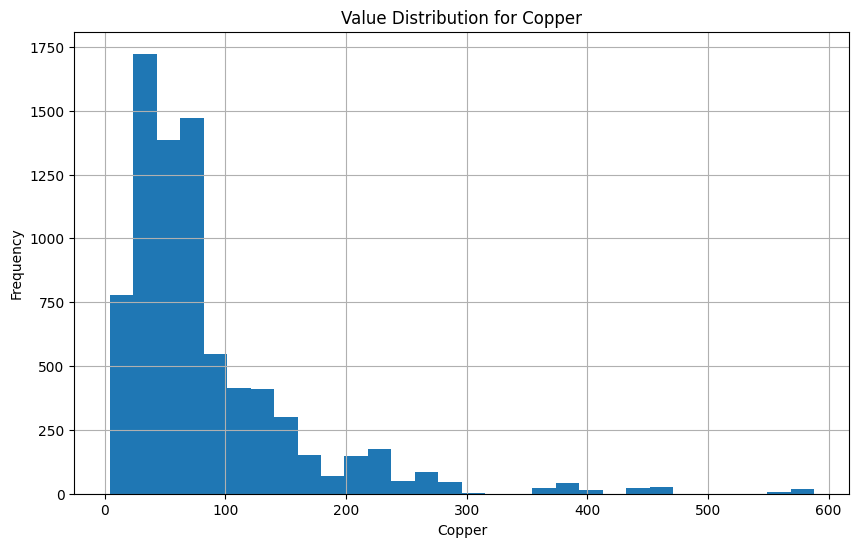

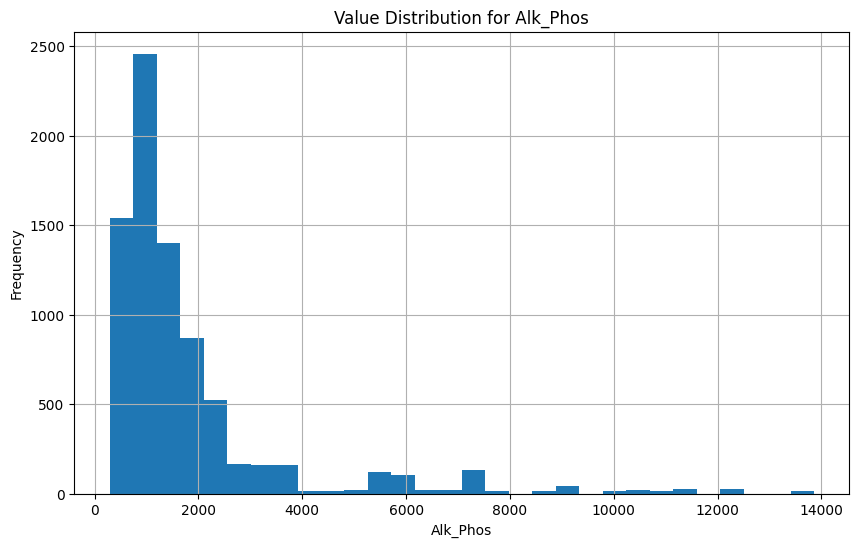

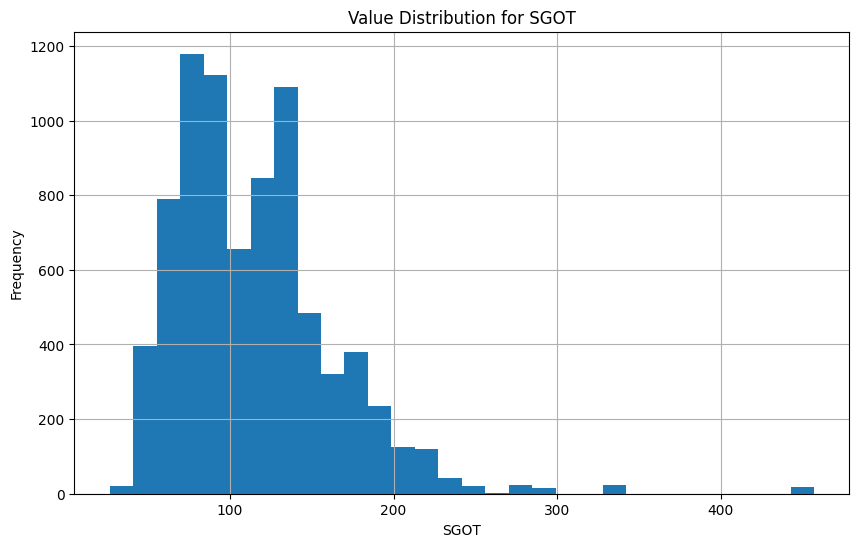

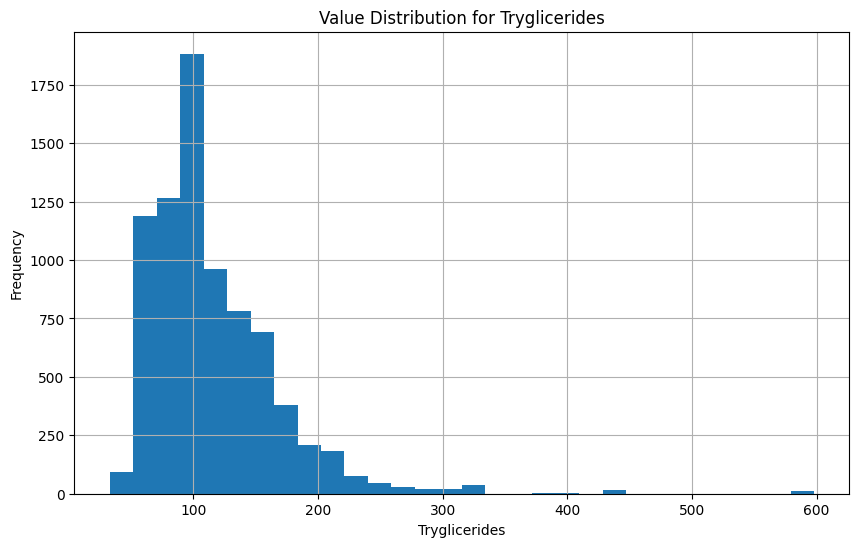

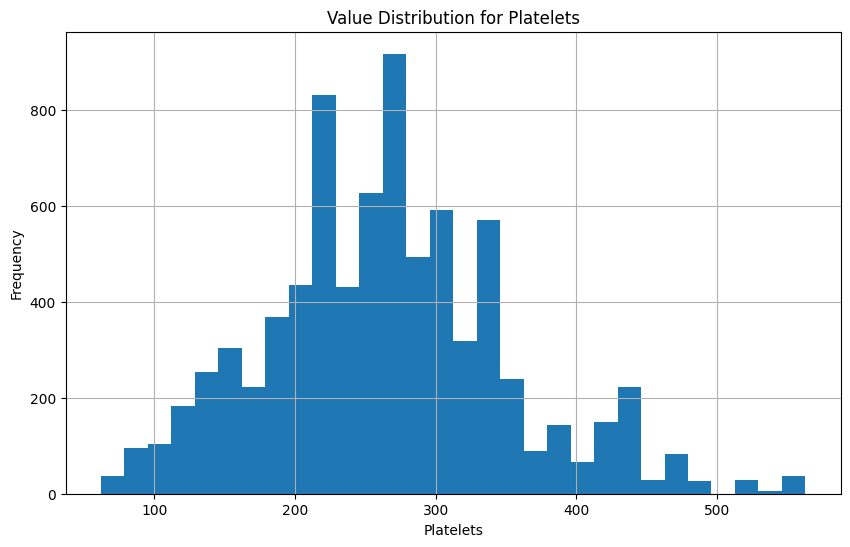

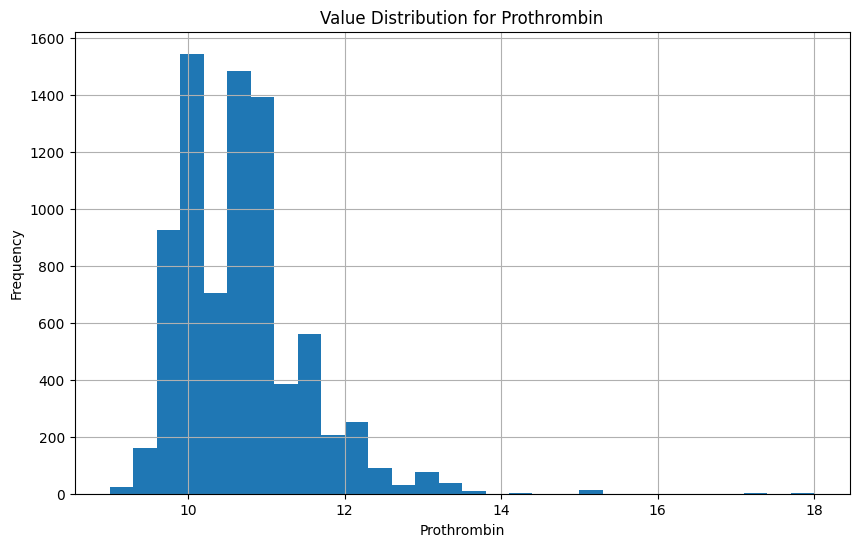

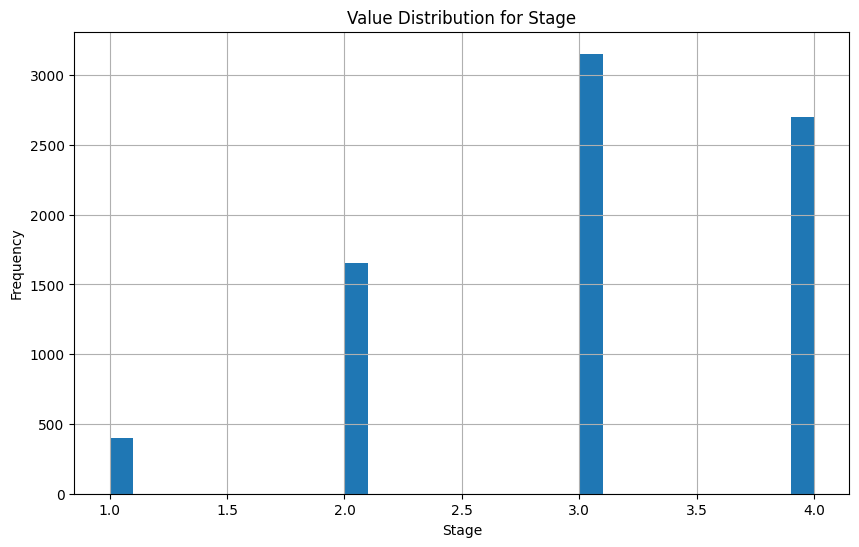

In [ ]:
# Создаем графики для признаков с дисбалансом
for column in imbalanced_numeric_features:
    plt.figure(figsize=(10, 6))

    # Строим гистограмму для каждого признака
    df_train[column].hist(bins=30)
    plt.title(f'Value Distribution for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Отображаем график на экране
    plt.show()


    # Сохраняем каждый график как картинку
    plt.savefig(f'{column}_value_distribution.png')
    plt.close()

<ipython-input-91-518fbc179d74>:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_train, x=feature, hue='Status', common_norm=False, fill=False, linewidth=2)


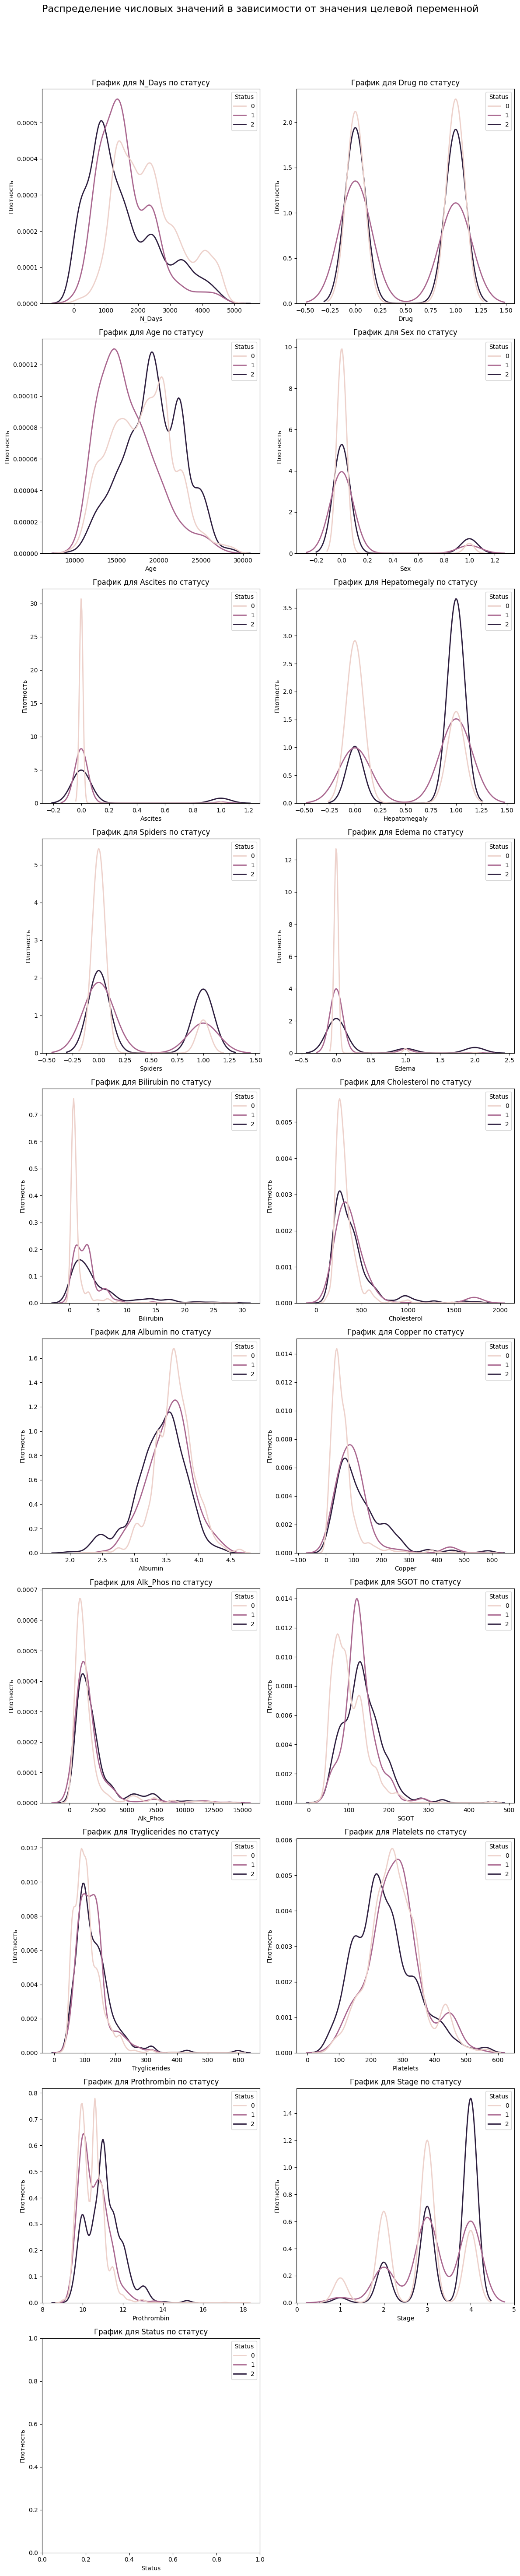

In [ ]:
# Построим графики зависмости числовых переменных и целевой переменной
numerical_features = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Определим количество подграфиков
num_features = len(numerical_features)
cols = 2  # Количество столбцов
rows = (num_features + 1) // cols  # Расчет количества строк

# Создадим общее полотно
plt.figure(figsize=(12, 6 * rows))

# Создадим графики для каждой числовой переменной в зависимости от целевой переменной "Status"
for i, feature in enumerate(numerical_features):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(data=df_train, x=feature, hue='Status', common_norm=False, fill=False, linewidth=2)
    plt.title(f'График для {feature} по статусу')
    plt.xlabel(feature)
    plt.ylabel('Плотность')

# Добавим общий заголовок
plt.suptitle('Распределение числовых значений в зависимости от значения целевой переменной', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Для удобства размещения заголовка
plt.show()

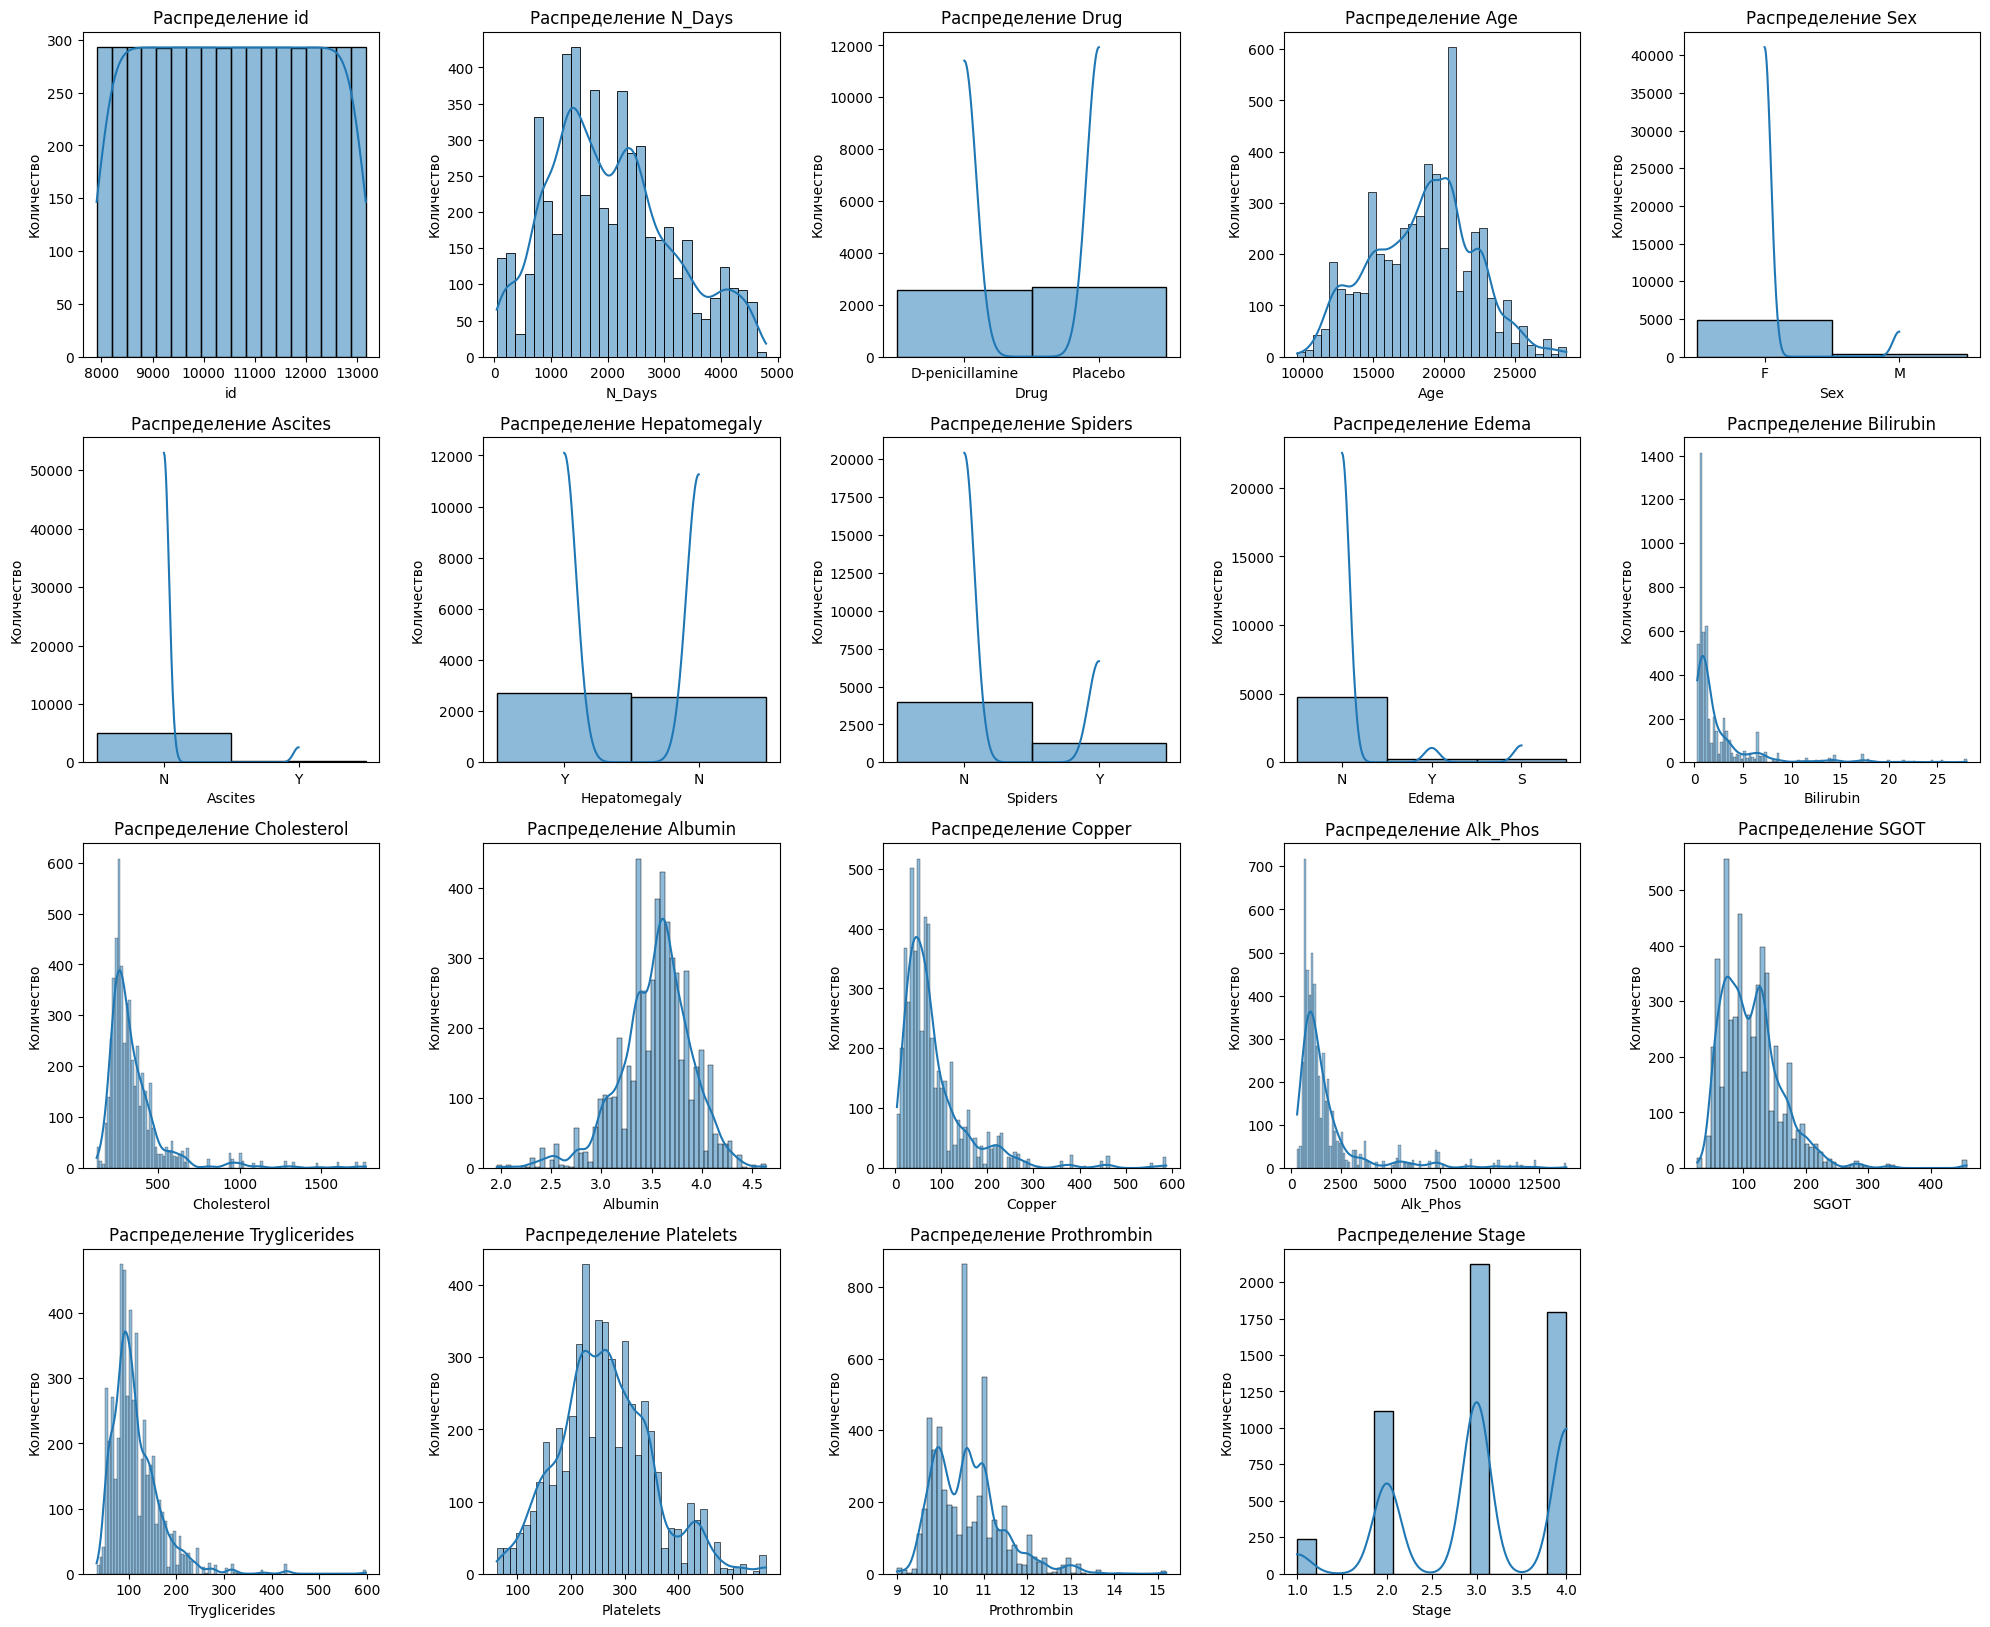

In [ ]:
# Изучим распределение данных для test
# Установка размеров графиков
plt.figure(figsize=(20, 20))

# Перебор каждого столбца
for i, column in enumerate(df_test.columns):
    plt.subplot(5, 5, i + 1)  # 5 строк и 5 столбцов
    sns.histplot(df_test[column], kde=True)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')

plt.tight_layout()  # Убираем наложение графиков
plt.show()

Характер распределения данных сопоставим с тренировочной выборкой

## Преобразование данных
## Преобразуем категориальные данные

In [111]:
df_train = df_train.drop(['id'],axis=1)
df_train.head().style.set_properties(**{"background-color": "#A8DADC", "color": "black", "border": "1.5px solid White"})


In [121]:
from sklearn.preprocessing import LabelEncoder


# Определяем категориальные признаки
object_columns = df_train.select_dtypes(include=['object']).columns

# Инициализируем LabelEncoder
label_encoder = LabelEncoder()

# Конвертируем данные типа object  в численные значения:
for col in object_columns:
    df_train[col] = label_encoder.fit_transform(df_train[col])

df_train.head(20).style.set_properties(**{"background-color": "#A8DADC", "color": "black", "border": "1.5px solid White"})



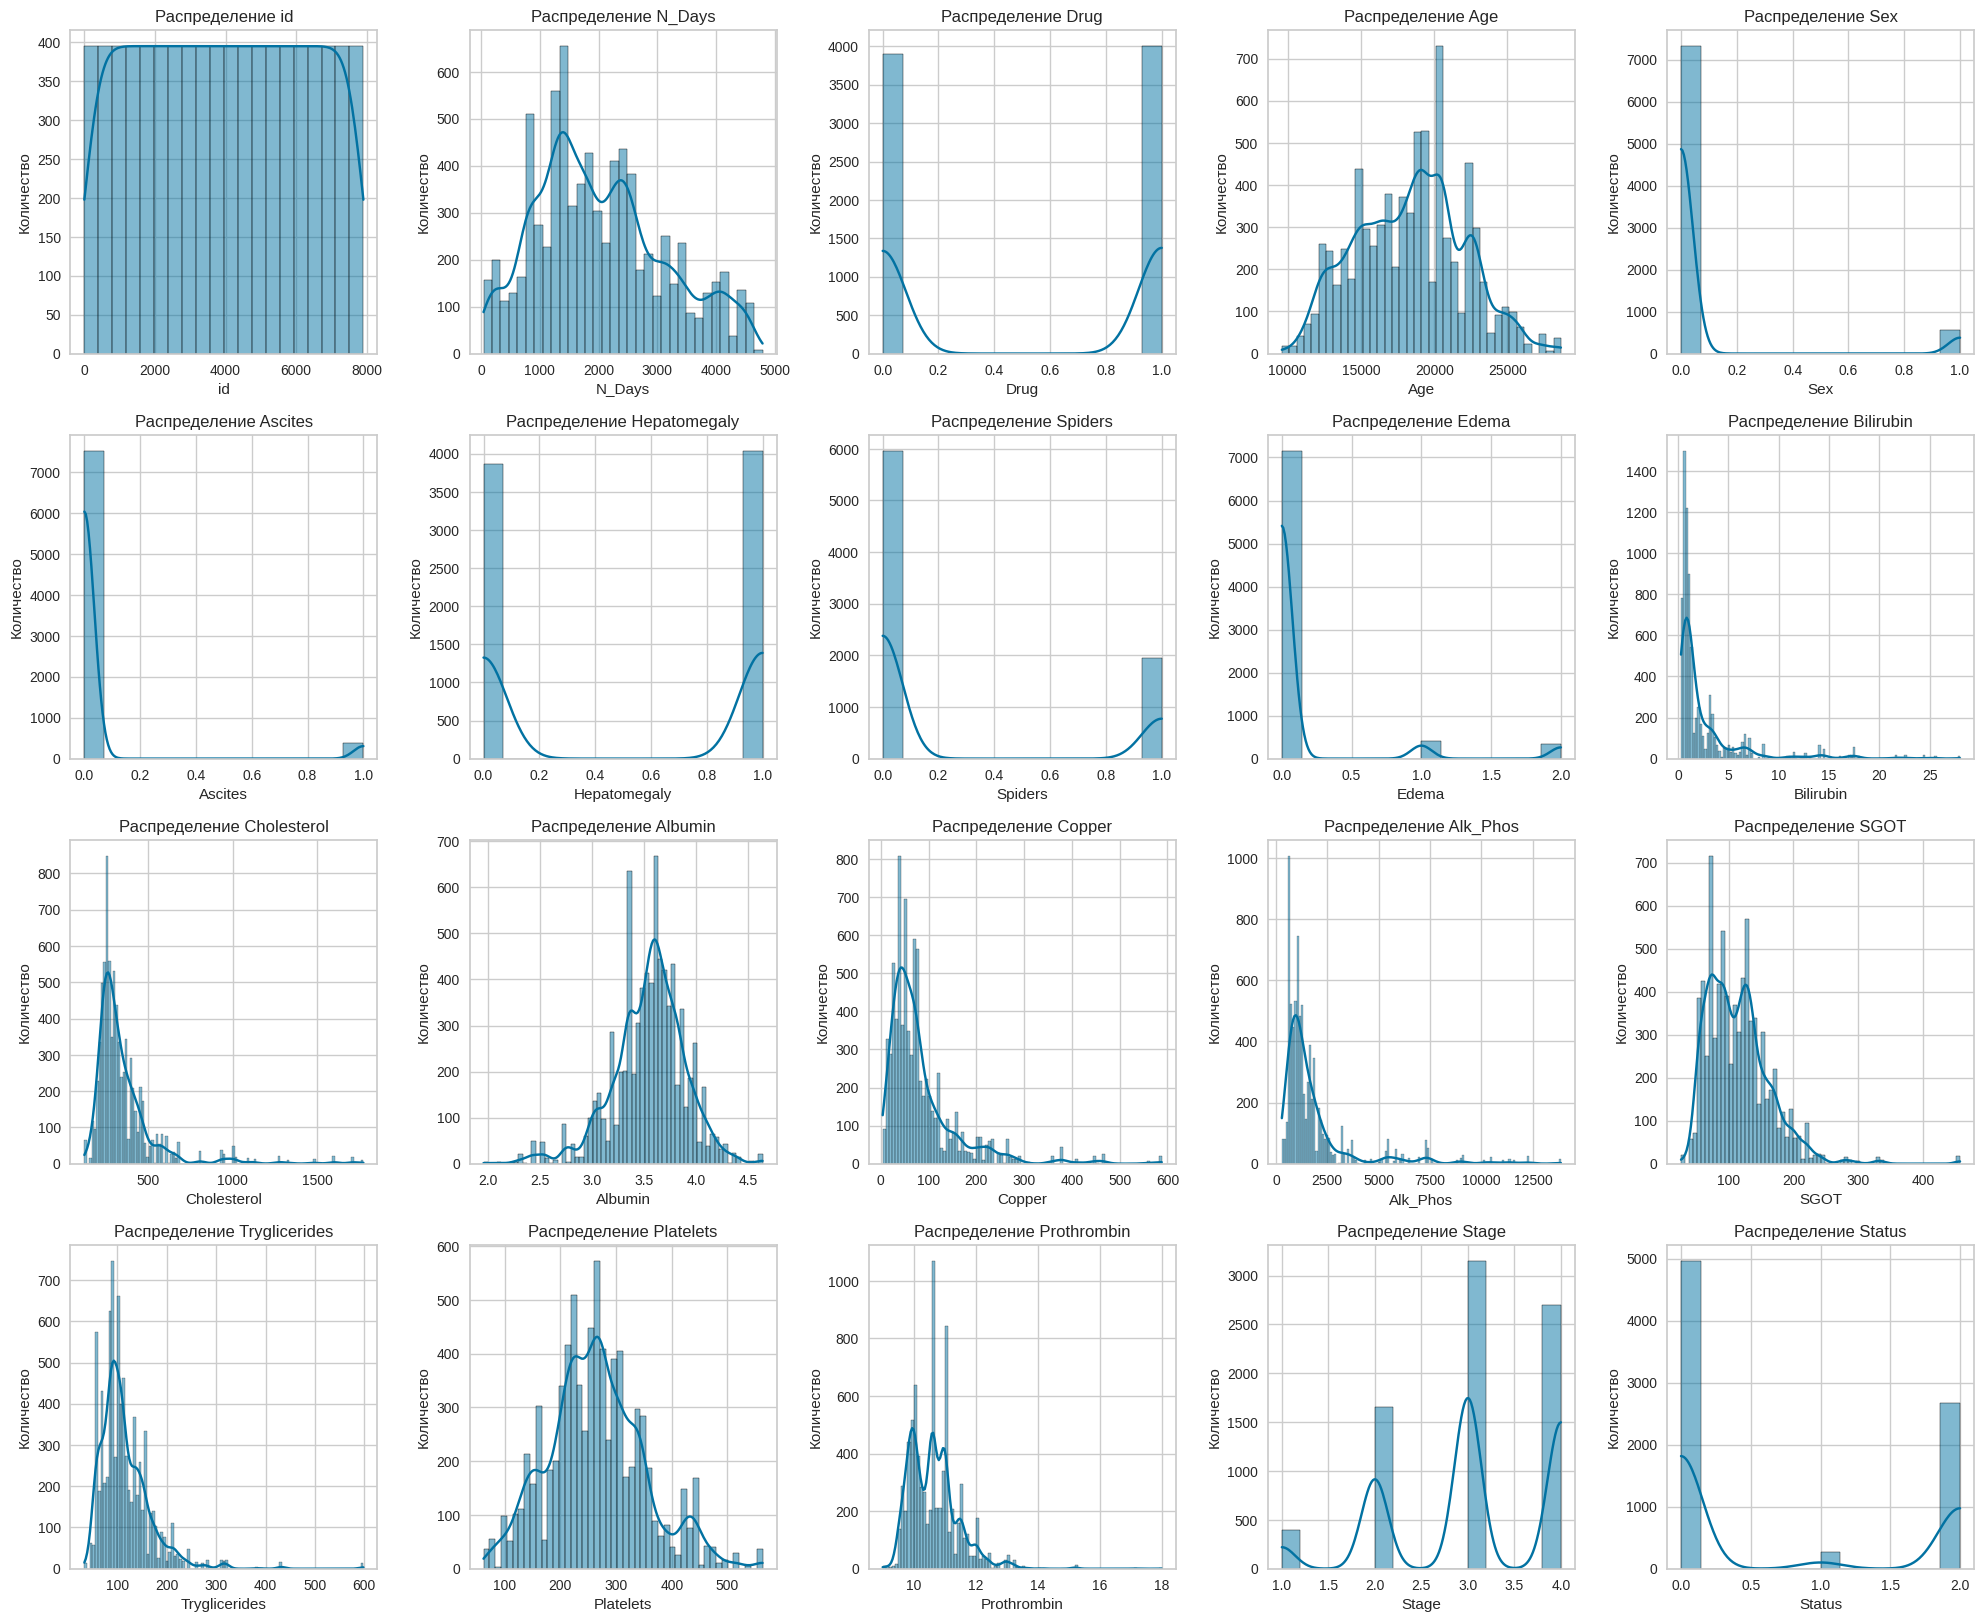

In [122]:
# Посмотрим распределение данных для train с преобразованием категориальных признаков
# Установка размеров графиков
plt.figure(figsize=(20, 20))

# Перебор каждого столбца
for i, column in enumerate(df_train.columns):
    plt.subplot(5, 5, i + 1)  # 5 строк и 5 столбцов
    sns.histplot(df_train[column], kde=True)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')

plt.tight_layout()  # Убираем наложение графиков
plt.show()

In [70]:
# Убедимся еще раз в типе данных
df_train.dtypes

id                 int64
N_Days             int64
Drug               int64
Age                int64
Sex                int64
Ascites            int64
Hepatomegaly       int64
Spiders            int64
Edema              int64
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status             int64
dtype: object

In [113]:
# Преобразуем данные для выборки test
# Определяем столбцы со значением типа object
object_columns1 = df_test.select_dtypes(include=['object']).columns

# Инициализируем LabelEncoder
label_encoder = LabelEncoder()

# Конвертируем в числовые значения:
for col in object_columns1:
    df_test[col] = label_encoder.fit_transform(df_test[col])

In [ ]:
# Убедимся еще раз в типе данных
df_test.dtypes

id                 int64
N_Days             int64
Drug               int64
Age                int64
Sex                int64
Ascites            int64
Hepatomegaly       int64
Spiders            int64
Edema              int64
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

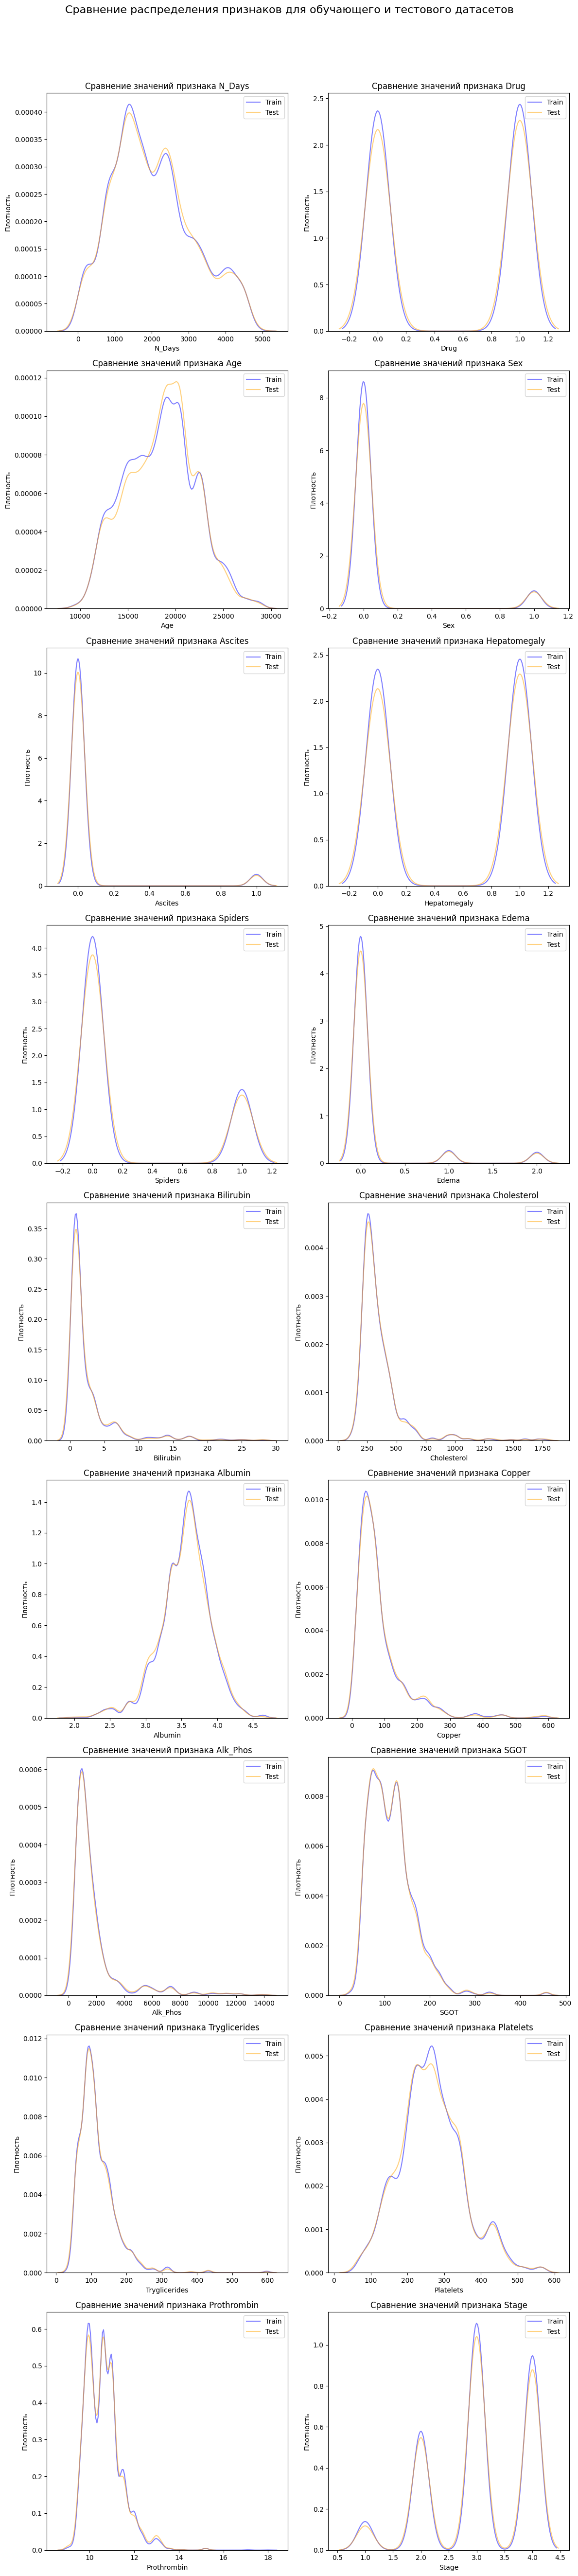

In [ ]:
# Выполним сравнение признаков двух выборок
features = ['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
            'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin',
            'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets',
            'Prothrombin', 'Stage']  # Замените на ваши признаки

# Определение количества подграфиков
num_features = len(features)
cols = 2  # Количество столбцов
rows = (num_features + 1) // cols  # Расчет количества строк

# Создадим общее полотно
plt.figure(figsize=(12, 6 * rows))

# Создадим графики для каждой переменной на одном полотне
for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)

    # Построение графика для обучающего датасета
    sns.kdeplot(df_train[feature], label='Train', color='blue', alpha=0.5)

    # Построение графика для тестового датасета
    sns.kdeplot(df_test[feature], label='Test', color='orange', alpha=0.5)

    plt.title(f'Сравнение значений признака {feature}')
    plt.xlabel(feature)
    plt.ylabel('Плотность')
    plt.legend()

# Добавьте общий заголовок
plt.suptitle('Сравнение распределения признаков для обучающего и тестового датасетов', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Для удобства расположения заголовка
plt.show()

### Создаем модель, оцениваем модель

In [124]:
# Разделим данные на признаки и целевую переменную
X = df_train.drop(['Status'], axis=1)
y = df_train['Status']

# Нормализация признаков с использованием RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели

accuracy_initial = accuracy_score(y_test, y_pred)
print(f'Accuracy (Initial): {accuracy_initial:.2f}')

confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', report)

Accuracy (Initial): 0.79
Confusion Matrix:
 [[888   0  78]
 [ 35   0  17]
 [197   0 366]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       966
           1       0.00      0.00      0.00        52
           2       0.79      0.65      0.71       563

    accuracy                           0.79      1581
   macro avg       0.53      0.52      0.52      1581
weighted avg       0.77      0.79      0.77      1581



Точность без новых признаков  0.79

# **Сгенерируем** новые признаки:
1) Liver_function -степень нарушения функции печени, определяется как Bilirubin/Albumin
2) Inflammation - воспалительные процессы в печени, определяется как отношение щелочной фосфотазы к уровню АСТ Alk_Phos/SGOT
3) Normal_Platelets - скорректированный уровень тромбоцитов. Поскольку тромбоциты часто уменьшаются при циррозе, их нормализация относительно средней по популяции может дать представление о текущем уровне здоровья пациента. Определяется как Platelets/Stage
4) Normal_Albumin - нормализованный по отекам альбумин. Учитывая, что наличие отеков может свидетельствовать о тяжелых нарушениях функции печени, альбумин можно нормировать с учетом признака Edema. Определяется как Albumin/(1+Edema)
5) Liver_damage - суммарный показатель поражения печени. Признаки, такие как Ascites, Hepatomegaly, Spiders можно суммировать, чтобы получить общий индекс осложнений печени. Формула: Ascites+Hepatomegaly+Spiders
6) Age_Group - возрастные группы пациентов: 0-30,30-50,50-70,70-100, соответственно: 'Young', 'Middle_Aged', 'Senior', 'Elderly
7) High_risk - признак высокий риск который принимает значение 1, если выполняются следующие условия (одновременно): Bilirubin > 2 Copper > 140 Alk_Phos > 150
7) ALBI - признак отношения билирубина к альбумину который используется для диагностики цироза печени


In [125]:
# 1) Liver_function = Bilirubin / Albumin
df_train['Liver_function'] = df_train['Bilirubin'] / df_train['Albumin']

# 2) Inflammation = Alk_Phos / SGOT
df_train['Inflammation'] = df_train['Alk_Phos'] / df_train['SGOT']

# 3) Normal_Platelets = Platelets / Stage
df_train['Normal_Platelets'] = df_train['Platelets'] / df_train['Stage']

# 4) Normal_Albumin = Albumin / (1 + Edema)
df_train['Normal_Albumin'] = df_train['Albumin'] / (1 + df_train['Edema'])

# 5) Liver_damage = Ascites + Hepatomegaly + Spiders
df_train['Liver_damage'] = df_train['Ascites'] + df_train['Hepatomegaly'] + df_train['Spiders']

# 6) Age_Group: создание возрастных групп на основе возраста в днях
def categorize_age_in_days(age_days):
    if age_days <= 10950:  # 0-30 лет
        return 'Young'
    elif 10950 < age_days <= 18250:  # 30-50 лет
        return 'Middle_Aged'
    elif 18250 < age_days <= 25550:  # 50-70 лет
        return 'Senior'
    else:  # 70-100 лет
        return 'Elderly'

df_train['Age_Group'] = df_train['Age'].apply(categorize_age_in_days)

# 6) признак высокий риск который принимает значение 1, если выполняются следующие условия (одновременно): Bilirubin > 2 Copper > 140 Alk_Phos > 150
df_train['High_Risk'] = ((df_train['Bilirubin'] > 2) &
                   (df_train['Copper'] > 140) &
                   (df_train['Alk_Phos'] > 150)).astype(int)

# 7) признак отношения билирубина к альбумину который используется для диагностики цироза печени
df_train['ALBI'] = (np.log10(df_train['Bilirubin']) * 0.66) - (df_train['Albumin'] * 0.085)

df_train['Age_Stage_Coefficient'] = df_train['Age'] / df_train['Stage']

# Преобразование категориальных значений в числовые
label_encoder = LabelEncoder()
df_train['Age_Group'] = label_encoder.fit_transform(df_train['Age_Group'])  #`Age_Group` если возраста будут закодированы как `{'Young': 0, 'Middle_Aged': 1, 'Senior': 2, 'Elderly': 3}

# Вывод первых нескольких строк для проверки
print(df_train.head())

# Обновляем данные для обучения и тестирования с новыми признаками
X_new = df_train.drop(['Status'], axis=1)
X_scaled_new = scaler.fit_transform(X_new)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled_new, y, test_size=0.2, random_state=42)

# Создание и оценка модели логистической регрессии после добавления признаков
model.fit(X_train_new, y_train_new)
y_pred_new = model.predict(X_test_new)

# Оценка модели
accuracy_new = accuracy_score(y_test_new, y_pred_new)
print(f'Accuracy (After Adding Features): {accuracy_new:.2f}')

# Вывод сравнения точности
print(f'Accuracy Improvement: {accuracy_new - accuracy_initial:.2f}')



   id  N_Days  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0   0     999     0  21532    1        0             0        0      0   
1   1    2574     1  19237    0        0             0        0      0   
2   2    3428     1  13727    0        0             1        1      2   
3   3    2576     1  18460    0        0             0        0      0   
4   4     788     1  16658    0        0             1        0      0   

   Bilirubin  ...  Status  Liver_function  Inflammation  Normal_Platelets  \
0        2.3  ...       2        0.686567      8.904338        131.333333   
1        0.9  ...       0        0.254237     10.678532        120.333333   
2        3.3  ...       2        0.929577      8.621701         49.750000   
3        0.6  ...       0        0.171429     23.183731         89.666667   
4        1.1  ...       0        0.301370      9.406611         74.500000   

   Normal_Albumin  Liver_damage  Age_Group  High_Risk      ALBI  \
0        3.350000        

In [126]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
# Создание и обучение модели случайного леса
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_new, y_train_new)

# Отбор лучших 10 признаков
selector = SelectFromModel(rf_model, threshold=-np.inf, max_features=10, prefit=True)
X_train_selected = selector.transform(X_train_new)
X_test_selected = selector.transform(X_test_new)

# Обучение модели на отобранных признаках
rf_model_selected = RandomForestClassifier(random_state=42)
rf_model_selected.fit(X_train_selected, y_train_new)

# Предсказание и оценка точности модели с отбором признаков
y_pred_selected = rf_model_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test_new, y_pred_selected)

# Вывод результатов
print(f'Accuracy (Random Forest with Feature Selection): {accuracy_selected:.2f}')

Accuracy (Random Forest with Feature Selection): 0.82


Вывод: получены достаточно интересные новые признаки с хорошими показателями степени важности: Liver_function, ALBI, Normal_Albumin, Normal_Platelets, которые вошли в 10 самых важных признаков. Признак Liver_damage оказался сопоставим со стадией заболевания, а возрастная группа значительно менее важна по сравнению с возрастом. Не вошедшие в топ-10 признаки можно исключить. Следует отметить, что начальная модель показывала точность 0.79, модель с новыми признаками- точность 0.8, модель с отбором лучших 10 признаков (количество подобрано на основании анализа точности в зависимости от количества признаков) точность выросла до 0.81 (3,79%)

In [127]:
# Сохраняем только нужные признаки
desired_columns = [
    'N_Days', 'Liver_function', 'ALBI',
    'Bilirubin', 'Prothrombin', 'Copper',
    'Normal_Albumin', 'Age', 'SGOT', 'Normal_Platelets'
]
df_train_filtered = df_train[desired_columns + ['Status']]

# Разделим данные на признаки и целевую переменную
X1 = df_train_filtered.drop(['Status'], axis=1)
y1 = df_train_filtered['Status']


# Разделение данных на обучающую и тестовую выборки
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
rf_model1 = RandomForestClassifier(random_state=42)
rf_model1.fit(X1_train, y1_train)

# Предсказание и оценка модели
y1_pred = rf_model1.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
confusion = confusion_matrix(y1_test, y1_pred)
report = classification_report(y1_test, y1_pred)

# Вывод результатов
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.82
Confusion Matrix:
[[894   2  70]
 [ 28   4  20]
 [164   3 396]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       966
           1       0.44      0.08      0.13        52
           2       0.81      0.70      0.76       563

    accuracy                           0.82      1581
   macro avg       0.69      0.57      0.59      1581
weighted avg       0.81      0.82      0.81      1581



удаление признаков не повиляло на полученный ранее результат, что подтверждает правильность выполненных действий! Ура!
---

